#   Title:   Personally Identifiable Information (PII) Model
##  Models  : DeBERTa with Long Short Term Memory (LSTM)
##  Author : Tinotenda Rodney Alfaneti and Bethel Panashe Choto
## Date   : April 6, 2024
## Course : Machine Learning


References

[A Hybrid BERT Model That Incorporates Label Semantics via Adjustive Attention for Multi-Label Text Classification Research Paper](https://ieeexplore.ieee.org/document/9169885/)


[DeBerta - Research Paper](https://medium.com/dair-ai/papers-explained-08-deberta-a808d9b2c52d)


[Joseph Josia - PIIDD Deberta Model Starter]()

[pii mixtral8x7b-generated-essay (additional data)](https://www.kaggle.com/datasets/nbroad/pii-dd-mistral-generated)

#### Import libraries

We are importing necessary libraries and setting up the environment for a processing the PII project. This includes data preprocessing, visualization, model training, evaluation, and utilizing transformer-based architectures for token classification tasks.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os, gc, re, warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

import torch

# libraries for metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# libraries for converting the numeric values during calculating metrics
from sklearn.preprocessing import MultiLabelBinarizer
from itertools import chain

# library to create our dataset
from datasets import Dataset

#libraries for pretraining
from transformers import AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoModelForTokenClassification, DataCollatorForTokenClassification

# metrics
from functools import partial

# libraries for loading and splitting data
import json
import pandas as pd
from sklearn.model_selection import train_test_split

#libraries for LSTM
import torch.nn as nn

# from transformers import AutoModelForTokenClassification, DebertaTokenizer
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim

# provides a progress bar for loops and functions
from tqdm import tqdm

# Importing AdamW optimizer from the torch.optim module for optimizing neural network parameters with weight decay.
from torch.optim import AdamW

warnings.filterwarnings("ignore")

2024-04-06 02:09:41.955016: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 02:09:41.955118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 02:09:42.091495: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
"""
seqeval is a Python framework for sequence labeling evaluation. seqeval can evaluate the 
performance of chunking tasks such as named-entity recognition, part-of-speech tagging, 
semantic role labeling and so on.
"""
!pip install seqeval evaluate -q

import evaluate

## Loading Data

Here, we load the training and test data for a Kaggle competition in JSON format. Autogenerated data from a Kaggle dataset is also incooparated. We then convert the data into Pandas DataFrames for visualization and further analysis.

In [3]:
# Loading train data and test data from the Kaggle competition in JSON format.
train_data = json.load(open('/kaggle/input/pii-detection-removal-from-educational-data/train.json'))
test_data = json.load(open('/kaggle/input/pii-detection-removal-from-educational-data/test.json'))

# Loading additional autogenerated data from a Kaggle datasets in JSON file format
additional_data = json.load(open('/kaggle/input/mpware-mixtral-generated-data-modified/modified_autogenerated_data.json'))

# Creating Pandas DataFrames for data visualization
train_ = pd.DataFrame(train_data + additional_data)
test_ = pd.DataFrame(test_data)
additional_ = pd.DataFrame(additional_data)

#### cleaning autogenerated data

In [5]:
## change the string document to int

# import json


# # Function to map document IDs to numerical IDs starting from 20000
# def map_document_ids(data):
#     current_id = 20000
#     id_mapping = {}
#     for item in data:
#         old_document_id = item["document"]
#         new_document_id = current_id
#         id_mapping[old_document_id] = new_document_id
#         item["document"] = new_document_id
#         current_id += 1
#     return id_mapping

# # Apply mapping to data
# id_mapping = map_document_ids(additional_data)

# # Write the modified data back to JSON file
# with open('modified_data.json', 'w') as file:
#     json.dump(additional_data, file, indent=4)  # indent for pretty formatting

## Data Visualization

Displaying the first few rows of the DataFrame containing additional augmented data. This allows us to inspect the augmented data and understand its structure, which includes features and labels of the data.


In [71]:
# view the autogenerated code
additional_.head()

,document,full_text,tokens,trailing_whitespace,labels
0,20000,Storytelling Challenge: Crafting Compelling Na...,"[Storytelling, Challenge, :, Crafting, Compell...","[True, False, True, True, True, True, True, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,20001,Storytelling Challenge: The Power of Narrative...,"[Storytelling, Challenge, :, The, Power, of, N...","[True, False, True, True, True, True, True, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,20002,Storytelling Challenge: The Power of Narrative...,"[Storytelling, Challenge, :, The, Power, of, N...","[True, False, True, True, True, True, True, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,20003,Storytelling Challenge: Crafting Compelling Na...,"[Storytelling, Challenge, :, Crafting, Compell...","[True, False, True, True, True, True, True, Fa...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,20004,Storytelling Challenge: The Power of Narrative...,"[Storytelling, Challenge, :, The, Power, of, N...","[True, False, True, True, True, True, True, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


#### view structure of the data

Displaying the first few rows of the DataFrame containing train data. This allows us to inspect the train data and understand its structure, which includes its features and labels.

In [6]:
train_.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


#### visualize labels graph

To provide insights into the distribution of labels in the dataset, we create a bar chart illustrating the frequency of each unique label. This visualization helps in understanding the class imbalance and the relative prevalence of different labels within the dataset.

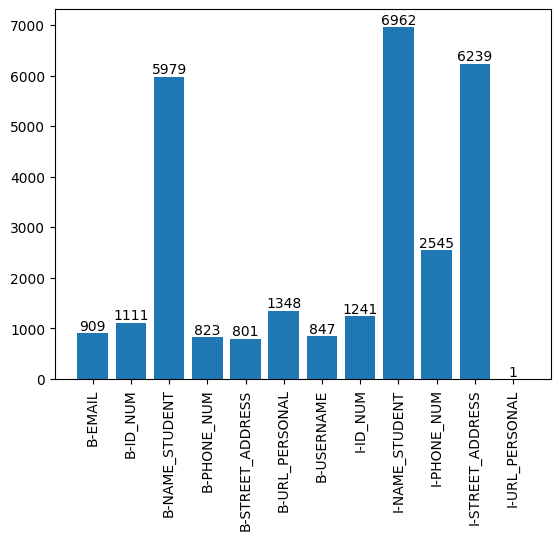

In [7]:
all_labels = np.concatenate(train_['labels'].values)
x, y = np.unique(all_labels,return_counts=True)

# leave out the O - Other class
x, y = x[:-1], y[:-1]

p = plt.bar(x, y)
plt.xticks(rotation=90)
plt.bar_label(p)
plt.show()


#### visualize the distribution of labels in the documents

We are creating a bar chart to visualize the distribution of personally identifiable information (PII) types across the essays in the training dataset. This visualization helps in understanding the prevalence of different PII types and their relative frequencies within the dataset. It provides insights into the distribution of sensitive information, which is crucial for understanding the nature and scope of the PII detection.


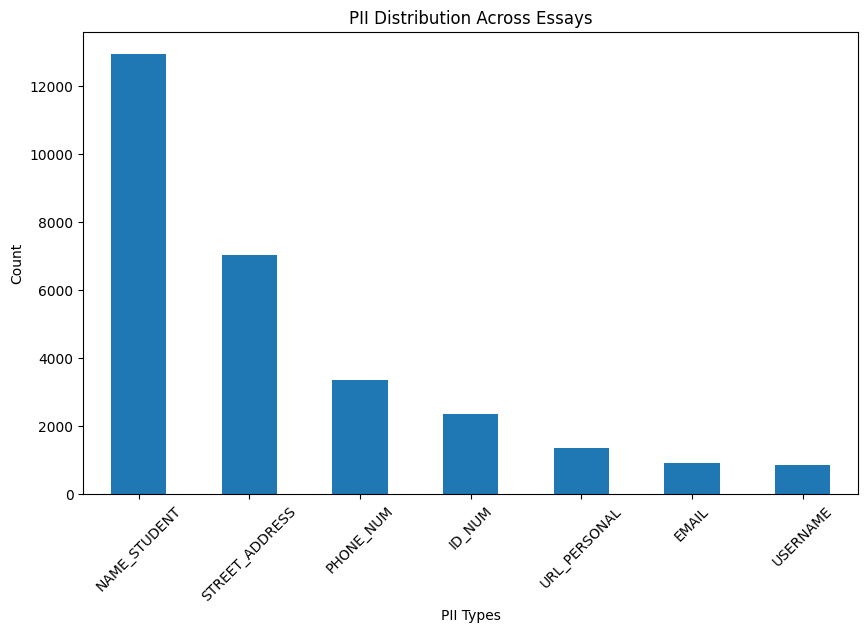

In [8]:
pii_distribution = train_['labels'].apply(lambda x: [label.split('-')[1] for label in x if '-' in label]).apply(pd.Series).stack().value_counts()
plt.figure(figsize=(10, 6))
pii_distribution.plot(kind='bar', stacked=True)
plt.title('PII Distribution Across Essays')
plt.xlabel('PII Types')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### visualize length of essays

We are creating a histogram to visualize the distribution of essay lengths in the training dataset. This visualization provides insights into the distribution of essay lengths, helping to understand the range and distribution of text lengths within the dataset.

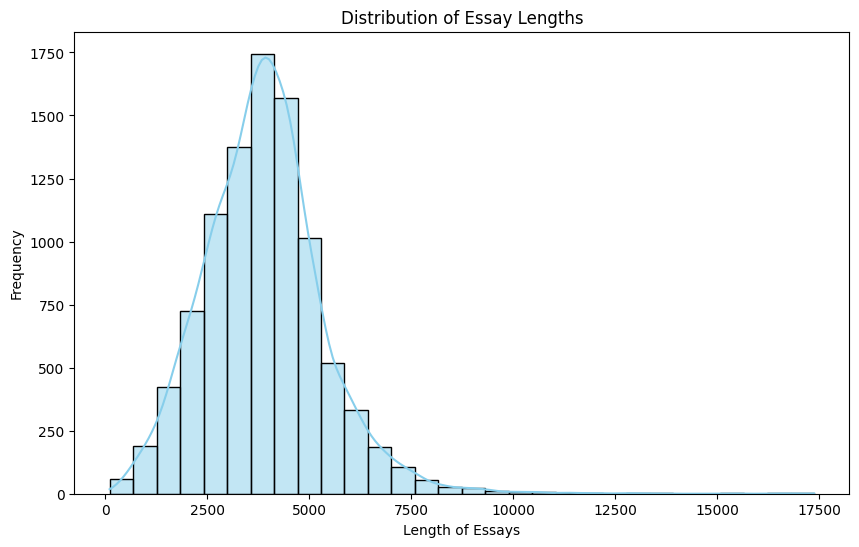

In [9]:
essay_lengths = train_['full_text'].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(essay_lengths, bins=30, kde=True, color='skyblue')
plt.title("Distribution of Essay Lengths")
plt.xlabel("Length of Essays")
plt.ylabel("Frequency")
plt.show()

#### create DatasetFromData class to create a dataset from the loaded data

The DatasetFromData class is designed to facilitate data management and preparation for a machine learning task. By providing methods to access validation, training, and testing data as Dataset objects, it streamlines the process of data handling and ensures consistency in data processing across different stages of model development. This abstraction allows for cleaner and more modular code, making it easier to manage and manipulate data for training and evaluation.


In [10]:
class DatasetFromData():
    """
        Initialize the DatasetFromData class.
        Args:
        - train_dir: Directory containing training data.
        - test_dir: Directory containing testing data.
        - add_data: Additional data to be added to the training set.
        - holdout: Percentage of data to be held out for validation. Default is 0.1 (10%).
    """
    
    def __init__(self, train_dir, test_dir, add_data, holdout=0.1):
        self.most_frequent_class = None
        self.train = train_dir
        self.test = test_dir
        self.holdout_start = int(0.1 * len(self.train))
        self.train_added = train_dir + add_data # add the additional data
    
    def get_validation_data(self):
        """
            Get validation data from the test set.
            Returns:
            - ds: Dataset object containing validation data.
        """
        ds = Dataset.from_dict({
            "full_text": [x["full_text"] for x in self.test],
            "document": [x["document"] for x in self.test],
            "tokens": [x["tokens"] for x in self.test],
            "trailing_whitespace": [x["trailing_whitespace"] for x in self.test],
        })
        
        return ds
    
    def get_train_data(self):
        """
            Get training data, including additional data removing the holdout data.
            Returns:
            - ds: Dataset object containing training data.
        """
        ds = Dataset.from_dict({
            "full_text": [self.train_added[x]["full_text"] for x in range(len(self.train_added)) if x >= self.holdout_start],
            "document": [self.train_added[x]["document"] for x in range(len(self.train_added)) if x >= self.holdout_start],
            "tokens": [self.train_added[x]["tokens"] for x in range(len(self.train_added)) if x >= self.holdout_start],
            "trailing_whitespace": [self.train_added[x]["trailing_whitespace"] for x in range(len(self.train_added)) if x >= self.holdout_start],
            "given_labels": [self.train_added[x]["labels"] for x in range(len(self.train_added)) if x >= self.holdout_start],
        })
        
        return ds
    
    def get_test_data(self):
        """
            Get testing data.
            Returns:
            - ds: Dataset object containing testing data.
        """
        ds = Dataset.from_dict({
            "full_text": [self.train[x]["full_text"] for x in range(len(self.train)) if x < self.holdout_start],
            "document": [self.train[x]["document"] for x in range(len(self.train)) if x < self.holdout_start],
            "tokens": [self.train[x]["tokens"] for x in range(len(self.train)) if x < self.holdout_start],
            "trailing_whitespace": [self.train[x]["trailing_whitespace"] for x in range(len(self.train)) if x < self.holdout_start],
            "given_labels": [self.train[x]["labels"] for x in range(len(self.train)) if x < self.holdout_start],
        })
        
        return ds

### create datasets from the data

Here, we initialize the DatasetFromData class with directories containing training, testing, and additional data for a machine learning task. By using the methods provided by the DatasetFromData class, we retrieve the training, validation, and testing data as Dataset objects.

In [11]:
# Initialize DatasetFromData class with training, testing, and additional data directories and retrive the results 
data_class = DatasetFromData(train_data,test_data, additional_data)
ds_train = data_class.get_train_data()
ds_val = data_class.get_validation_data()
ds_test = data_class.get_test_data()

#### Saving the Evaluations

This code block iterates through the testing dataset to extract information such as row IDs, documents, tokens, and labels, and stores them in separate lists. It then creates a DataFrame using these lists and saves it to a CSV file named "evaluations.csv".

In [12]:
# Initialize empty lists to store data
row_id = []
document = []
token = []
label = []

for i, (tokens, labels, doc) in enumerate(zip(ds_test["tokens"], ds_test["given_labels"], ds_test["document"])):
    if len(row_id) == 0:
        row_id.extend(range(len(tokens)))
    else:
        row_id.extend(range(row_id[-1] + 1,  row_id[-1] + 1 + len(tokens)))
        
    document.extend([doc] * len(tokens))
    token.extend(range(len(tokens)))
    label.extend(labels)

# Creating a DataFrame using pandas
evaluations = pd.DataFrame({
    "row_id": row_id,
    "document": document,
    "token": token,
    "label": label
})

# Saving DataFrame to CSV
evaluations.to_csv("evaluations.csv", index=False)

print(f"Evaluations saved to evaluations.csv")

Evaluations saved to evaluations.csv


## Fine-tuning DeBERTa model

Fine-tuning refers to the process of taking a pre-trained neural network model and further training it on a specific task or dataset.

#### initialize model path and output path and other constants

We defined a pre-trained model path, maximum tokenization length, output directory, device for training (GPU if available, otherwise CPU), and batch size ensures efficient and controlled training process, managing resources effectively and optimizing model performance.

In [13]:
# Define the pre-trained model to be used for training
TRAINING_MODEL_PATH = "microsoft/deberta-v3-base"
TRAINING_MAX_LENGTH =  512 # maximum number of tokens allowed in the tokenized output
OUTPUT_DIR = "output"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # device be used for training GPU if available otherwise Cpu
BATCH_SIZE = 4

#### create all_labels, map of label to id and then map of id to label

The code segment below compiles a comprehensive list of unique labels found in the training data, vital for various tasks such as metric computation. It establishes two dictionaries, `label2id` and `id2label`, enabling efficient label encoding and decoding processes for tokenization and model initialization.

In [14]:
# all_labels, collection important for metrics and other small tasks
#label2id and id2label are for the tokenizer and initializing model

from itertools import chain

all_labels = sorted(list(set(chain(*[x["labels"] for x in train_data]))))
label2id = {l: i for i,l in enumerate(all_labels)}
id2label = {v:k for k,v in label2id.items()}

print(id2label)
print(label2id)

{0: 'B-EMAIL', 1: 'B-ID_NUM', 2: 'B-NAME_STUDENT', 3: 'B-PHONE_NUM', 4: 'B-STREET_ADDRESS', 5: 'B-URL_PERSONAL', 6: 'B-USERNAME', 7: 'I-ID_NUM', 8: 'I-NAME_STUDENT', 9: 'I-PHONE_NUM', 10: 'I-STREET_ADDRESS', 11: 'I-URL_PERSONAL', 12: 'O'}
{'B-EMAIL': 0, 'B-ID_NUM': 1, 'B-NAME_STUDENT': 2, 'B-PHONE_NUM': 3, 'B-STREET_ADDRESS': 4, 'B-URL_PERSONAL': 5, 'B-USERNAME': 6, 'I-ID_NUM': 7, 'I-NAME_STUDENT': 8, 'I-PHONE_NUM': 9, 'I-STREET_ADDRESS': 10, 'I-URL_PERSONAL': 11, 'O': 12}


In [15]:
# can also do this computationally, by calling unique on all_labels then remove 'O'
target = [
    'B-EMAIL', 'B-ID_NUM', 'B-NAME_STUDENT', 'B-PHONE_NUM', 
    'B-STREET_ADDRESS', 'B-URL_PERSONAL', 'B-USERNAME', 'I-ID_NUM', 
    'I-NAME_STUDENT', 'I-PHONE_NUM', 'I-STREET_ADDRESS', 'I-URL_PERSONAL'
]

#### function to tokenize the labels utilizing the DeBERTa pretrained model tokenizer

We created a function `tokenize` which processes raw text and labels, tokenizes them using a provided tokenizer, and prepares the necessary data for training a sequence labeling model. It generates token IDs, attention masks, and integer labels based on the provided label-to-ID mapping, crucial for training and evaluation. 

In [16]:
def tokenize(example, tokenizer, label2id):
    
    """
    Tokenizes text and labels, prepares attention mask and target labels for training.

    Args:
        example (dict): Dictionary containing raw text and labels.
        label2id (dict): Mapping from label strings to integer IDs.

    Returns:
        dict: Dictionary containing processed data for training:
            - input_ids (list): List of token IDs.
            - attention_mask (list): List of attention mask values (0 for padding, 1 otherwise).
            - labels (list): List of integer labels for each token (according to label2id).
            - target_num (int): Number of target entities in the sequence.
            - group (int): 1 if target_num > 0, 0 otherwise (optional).

    """
    text = []
    labels = []
    targets = []
    token_map = []
    idx = 0

    for t, l, ws in zip(example["tokens"], example["given_labels"], example["trailing_whitespace"]):

        text.append(t)
        labels.extend([l]*len(t))
        token_map.extend([idx]*len(t))
        
        if l in target:
            targets.append(1)
        else:
            targets.append(0)
        # if there is trailing whitespace
        if ws:
            text.append(" ")
            labels.append("O")
            token_map.append(-1)
        idx += 1
    # passes the list of text and white spaces to the tokenizer passed as a parameter for tokenization    
    tokenized = tokenizer("".join(text), return_offsets_mapping=True, truncation=True, max_length=TRAINING_MAX_LENGTH, add_special_tokens=True, padding='max_length')
    
    target_num = sum(targets)
    labels = np.array(labels)
    text = "".join(text)
    token_labels = []
    
    for start_idx, end_idx in tokenized.offset_mapping:

        # CLS token
        if start_idx == 0 and end_idx == 0: 
            token_labels.append(label2id["O"])
            continue

        # case when token starts with whitespace
        if text[start_idx].isspace():
            start_idx += 1

        token_labels.append(label2id[labels[start_idx]])

    length = len(tokenized.input_ids)
    
    # Create attention mask (1 for valid tokens, 0 for padding)
    attention_mask = [1] * length  # Initialize with 1s for all tokens
    for idx, (start, end) in enumerate(tokenized.offset_mapping):
        if start == end:  # Padded token
            attention_mask[idx] = 0
    # Convert labels to IDs
    label_ids = [label2id[label] for label in labels]

    return {
        **tokenized,
        "labels": token_labels, # labels the pretrained model will use
        "length": length,
        "target_num": target_num,
        "input_ids": tokenized.input_ids,
        "attention_mask": attention_mask,
        "group": 1 if target_num>0 else 0,
        "label_ids": token_labels,
        "token_map": token_map
    }

The code below initializes a tokenizer object by loading a pre-trained tokenizer associated with the specified model path (TRAINING_MODEL_PATH). The AutoTokenizer.from_pretrained method automatically selects and loads the appropriate tokenizer based on the provided model path. 

In [17]:
# initialize the tokenizer from DeBERTa model
tokenizer = AutoTokenizer.from_pretrained(TRAINING_MODEL_PATH)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

#### tokenizing training data

In [18]:
# tokenizing the training data, getting ready for fine-tuning
ds_train = ds_train.map(tokenize, fn_kwargs={"tokenizer": tokenizer, "label2id": label2id},remove_columns=["full_text", "document", "tokens","given_labels", "trailing_whitespace"], num_proc=2)
ds = ds_train.class_encode_column("group") # perform class encoding on the "group" column of the dataset

#0:   0%|          | 0/4410 [00:00<?, ?ex/s]

#1:   0%|          | 0/4409 [00:00<?, ?ex/s]

Stringifying the column:   0%|          | 0/9 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/9 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [19]:
# remove token map
ds = ds.remove_columns(['token_map'])

#### tokenizing the test data (holdout test data)

In [20]:
ds_test = ds_test.map(tokenize, fn_kwargs={"tokenizer": tokenizer, "label2id": label2id}, num_proc=2)
ds_test = ds_test.class_encode_column("group")

#0:   0%|          | 0/340 [00:00<?, ?ex/s]

#1:   0%|          | 0/340 [00:00<?, ?ex/s]

Stringifying the column:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [21]:
ds_test_val = ds_test.remove_columns(['token_map', "full_text", "document", "tokens","given_labels", "trailing_whitespace"])

#### define method for calculating the metrics - recall, precision, f1, accuracy utilizing the seqeval module

This function compute_accuracy calculates the overall accuracy by comparing predictions with true labels for sequence labeling tasks.

In [22]:
def compute_accuracy(predictions, labels):
    correct = 0
    total = 0
    for preds, true_labels in zip(predictions, labels):
        for pred, true_label in zip(preds, true_labels):
            if pred == true_label:
                correct += 1
            total += 1
    return correct / total if total > 0 else 0.0

We define a function `compute_metrics` that computes evaluation metrics such as recall, precision, accuracy, and F1 score for sequence labeling tasks using the Seqeval library. It extracts true predictions and labels, excluding special tokens, and calculates these metrics based on the extracted sequences.Then it returns the computed metrics.

In [23]:
from seqeval.metrics import recall_score, precision_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score

def compute_metrics(p, all_labels):
    predictions, labels = p
    
    # Remove ignored index (special tokens)
    true_predictions = [
        [all_labels[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [all_labels[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    recall = recall_score(true_labels, true_predictions)
    precision = precision_score(true_labels, true_predictions)
    accuracy = compute_accuracy(predictions, labels)
    f1 = f1_score(true_labels, true_predictions)
    
    results = {
        'recall': recall,
        'precision': precision,
        'accuracy': accuracy,
        'f1': f1
    }
    return results

#### define the model

The DeBERTaBiLSTM model integrates DeBERTa, a transformer-based language model, with a bidirectional LSTM (BiLSTM) layer. This hybrid architecture combines DeBERTa's contextual understanding with BiLSTM's sequential processing capabilities. DeBERTa captures contextual information effectively, while the BiLSTM layer captures sequential patterns. 


During our training, we noticed that the LSTM performs better than the BiLSTM, we also noticed that adding Label Embeddings also lowered the metrics of the  model. Hence though the solution was to implement all of them, we then lowered it down to be a DeBERTa with LSTM and GELU activation

In [72]:
import torch
import torch.nn as nn
from transformers import DebertaV2Model
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class DeBERTaBiLSTM(nn.Module):
    def __init__(self, num_labels, pooling_type="mean"):
        """
            Initialize the DeBERTaBiLSTM model.
            Args:
            - num_labels (int): Number of output labels.
            - pooling_type (str): Type of pooling operation to be applied to DeBERTa outputs. Default is "mean".
        """
        super(DeBERTaBiLSTM, self).__init__()
        self.num_labels = num_labels
        self.deberta = DebertaV2Model.from_pretrained(TRAINING_MODEL_PATH, ignore_mismatched_sizes=True)
        self.bilstm = nn.LSTM(input_size=self.deberta.config.hidden_size, hidden_size=512, num_layers=1, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(512, num_labels)
        self.activation = nn.GELU() 

    def forward(self, input_ids, attention_mask):
        output = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = output.last_hidden_state 

        # Pack padded sequence for BiLSTM
        packed_output = pack_padded_sequence(sequence_output, lengths=torch.sum(attention_mask, dim=1).cpu(), batch_first=True, enforce_sorted=False)
     
        # Apply BiLSTM
        lstm_output, _ = self.bilstm(packed_output)
     
        # Pad packed sequence
        lstm_output, _ = pad_packed_sequence(lstm_output, batch_first=True)

        # Linear layer
        logits = self.fc(lstm_output)

        # Applying GELU activation
        activated_logits = self.activation(logits)

        return activated_logits


Initializing a model named 'model' using the DeBERTaBiLSTM architecture with the number of output labels specified by len(all_labels).


In [50]:
# Initializing a model named 'model' using the DeBERTaBiLSTM architecture with the number of output labels specified by len(all_labels).
model = DeBERTaBiLSTM(len(all_labels))

#### split the data into train and validation

In [51]:
final_ds = ds.train_test_split(test_size=0.1, seed=32) # cannot use stratify_by_column='group'

In [52]:
# using a collator for padding sequences - deal with variable lengths
collator = DataCollatorForTokenClassification(tokenizer, pad_to_multiple_of=16, padding=True, return_tensors="pt")

#### defining the Trainer class for the model

The Trainer class coordinates the complete training and evaluation workflow for the DeBERTaBiLSTM model, seamlessly managing data preprocessing, model optimization, and performance assessment. Throughout our experimentation, we explored the potential benefits of integrating word embeddings into the model architecture. However, after observing a significant decrease in F1 score during initial trials, we made the decision to exclude word embeddings from the final model configuration to prioritize performance.



In [53]:
import torch
from torch.utils.data import DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

EPOCHS = 5
LR = 2e-5

class Trainer:
    def __init__(self, model, train_dataset, val_dataset, max_seq_length=TRAINING_MAX_LENGTH, epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=LR):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")# to utilize GPU when it's available
        self.model = model.to(self.device)
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.max_seq_length = max_seq_length  # Maximum sequence length
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        
        # we tried the SGD and the AdamW, and we noticed that the AdamW was perfoming better a an optimization function
        self.optimizer = AdamW(self.model.parameters(), lr=self.learning_rate)
        # self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)

        # Initializes a learning rate scheduler with a linear decay schedule and warmup phase, adapting the learning rate during training.
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps=0, num_training_steps=len(train_dataset) * epochs)
        
        # the loss function we settled on is CrossEntropyLoss
        self.loss_fn = nn.CrossEntropyLoss()
        
        # these variables are for early stopping when the models stops making significant changes in validation loss
        self.best_val_loss = float('inf')
        self.num_epochs_no_improve = 0
        self.max_epochs_no_improve = 3  # Adjust as needed
    
    def pad_sequence(self, sequence, max_length):
        """Pad or truncate a sequence to the specified max_length."""
        if len(sequence) < max_length:
            # Pad sequence with zeros
            sequence += [-100] * (max_length - len(sequence))
        elif len(sequence) > max_length:
            # Truncate sequence
            sequence = sequence[:max_length]
        return sequence
    
    def pad_sequence_eval(self, sequence, max_length):
        """Pad or truncate a sequence to the specified max_length."""
        if len(sequence) < max_length:
            # Pad sequence with zeros
            padded_sequence = torch.cat((sequence, torch.zeros(max_length - len(sequence), dtype=torch.long)))
        elif len(sequence) > max_length:
            # Truncate sequence
            padded_sequence = sequence[:max_length]
        else:
            padded_sequence = sequence
        return padded_sequence

    def train(self, perform_eval=True):
        train_dataloader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn=collator)
        val_dataloader = DataLoader(self.val_dataset, batch_size=self.batch_size, collate_fn=collator)

        for epoch in range(self.epochs):
            self.model.train()
            total_loss = 0

            # Initialize tqdm progress bar outside the epoch loop
            pbar = tqdm(total=len(train_dataloader), desc=f"Epoch {epoch + 1}/{self.epochs}", position=0, leave=True)

            for batch in train_dataloader:
                input_ids = pad_sequence(batch["input_ids"], batch_first=True, padding_value=-100).to(self.device)
                attention_mask = pad_sequence(batch["attention_mask"], batch_first=True, padding_value=-100).to(self.device)
                labels = pad_sequence(batch["labels"], batch_first=True, padding_value=-100).to(self.device)
#                 label_embeddings = pad_sequence(batch["label_ids"], batch_first=True, padding_value=-100).to(self.device)  # Get label embeddings

                # Forward pass
                self.optimizer.zero_grad()
                outputs = self.model(input_ids, attention_mask)

                # Adjust the sequence length of outputs and labels
                min_seq_length = min(outputs.size(1), labels.size(1))
                outputs = outputs[:, :min_seq_length, :]
                labels = labels[:, :min_seq_length]

                # Calculate the loss
                loss = self.loss_fn(outputs.reshape(-1, self.model.num_labels), labels.reshape(-1))

                # Backward pass and optimization
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()
                self.scheduler.step()

                total_loss += loss.item()

                # Update tqdm description dynamically
                pbar.set_description(f"Epoch {epoch + 1}/{self.epochs}, Training Loss: {loss.item():.4f}")
                pbar.update()

            avg_train_loss = total_loss / len(train_dataloader)
            print(f"Epoch {epoch + 1}/{self.epochs}, Average Training Loss: {avg_train_loss}")

            if perform_eval:
                val_loss, additional_metrics, _ = self.evaluate(val_dataloader)
                print(f"Epoch {epoch + 1}/{self.epochs}, Average Validation Loss: {val_loss}")
                print(f"Epoch {epoch + 1}/{self.epochs}, Evaluation Metrics - F1: {additional_metrics['f1']}, Accuracy: {additional_metrics['accuracy']}, Precision: {additional_metrics['precision']}, Recall: {additional_metrics['recall']}")

                # Check for early stopping
                if val_loss < self.best_val_loss:
                    self.best_val_loss = val_loss
                    self.num_epochs_no_improve = 0
                else:
                    self.num_epochs_no_improve += 1
                    if self.num_epochs_no_improve >= self.max_epochs_no_improve:
                        print(f'Validation loss has not improved for {self.max_epochs_no_improve} epochs. Stopping training.')
                        break

    def evaluate(self, dataloader):
        self.model.eval()
        total_loss = 0
        total_predictions = []
        total_labels = []

        with torch.no_grad():
            for batch in dataloader:
                input_ids = [torch.tensor(self.pad_sequence_eval(ids, self.max_seq_length), dtype=torch.long) for ids in batch["input_ids"]]
                attention_mask = [torch.tensor(self.pad_sequence_eval(mask, self.max_seq_length), dtype=torch.long) for mask in batch["attention_mask"]]
                labels = [torch.tensor(self.pad_sequence_eval(lbl, self.max_seq_length), dtype=torch.long) for lbl in batch["labels"]]

                input_ids = torch.stack(input_ids, dim=0).to(self.device)
                attention_mask = torch.stack(attention_mask, dim=0).to(self.device)
                labels = torch.stack(labels, dim=0).to(self.device)

                outputs = self.model(input_ids, attention_mask)

                # Adjust the sequence length of outputs and labels
                min_seq_length = min(outputs.size(1), labels.size(1))
                outputs = outputs[:, :min_seq_length, :]
                labels = labels[:, :min_seq_length]

                loss = self.loss_fn(outputs.reshape(-1, self.model.num_labels), labels.reshape(-1))
                total_loss += loss.item()

                predictions = torch.argmax(outputs, dim=-1).cpu().numpy().tolist()
                true_labels = labels.cpu().numpy().tolist()

                total_predictions.extend(predictions)
                total_labels.extend(true_labels)

        avg_loss = total_loss / len(dataloader)
        additional_metrics = compute_metrics((total_predictions, total_labels), all_labels)

        return avg_loss, additional_metrics, total_predictions

#### training the model

We measure the execution time required to instantiate the Trainer object and conduct training of the DeBERTaBiLSTM model using the training dataset, followed by evaluation using the test dataset. This step serves to provide empirical evidence of the model training process.


In [54]:
%%time
trainer = Trainer(model, final_ds["train"], final_ds["test"])
trainer.train()

Epoch 1/5, Training Loss: 0.0039: 100%|██████████| 993/993 [12:09<00:00,  1.76it/s]

Epoch 1/5, Average Training Loss: 0.20132462752721303
Epoch 1/5, Average Validation Loss: 0.12621033670976423
Epoch 1/5, Evaluation Metrics - F1: 0.6120042872454448, Accuracy: 0.9969409986216708, Precision: 0.6120042872454448, Recall: 0.6120042872454448


Epoch 2/5, Training Loss: 0.0205: 100%|██████████| 993/993 [12:09<00:00,  1.76it/s]

Epoch 2/5, Average Training Loss: 0.15235558668711183
Epoch 2/5, Average Validation Loss: 0.1174957459434072
Epoch 2/5, Evaluation Metrics - F1: 0.8055713473564524, Accuracy: 0.9987706193588547, Precision: 0.8577481840193705, Recall: 0.7593783494105038


Epoch 3/5, Training Loss: 0.0001: 100%|██████████| 993/993 [12:10<00:00,  1.76it/s]

Epoch 3/5, Average Training Loss: 0.14673339250257889
Epoch 3/5, Average Validation Loss: 0.11393828541556948
Epoch 3/5, Evaluation Metrics - F1: 0.8896034297963559, Accuracy: 0.9994820150282335, Precision: 0.8896034297963559, Recall: 0.8896034297963559


Epoch 4/5, Training Loss: 0.0034: 100%|██████████| 993/993 [12:08<00:00,  1.76it/s]

Epoch 4/5, Average Training Loss: 0.14432792732049332
Epoch 4/5, Average Validation Loss: 0.11294741857010841
Epoch 4/5, Evaluation Metrics - F1: 0.9194560669456068, Accuracy: 0.9994686763594327, Precision: 0.8978549540347294, Recall: 0.9421221864951769


Epoch 5/5, Training Loss: 0.0000: 100%|██████████| 993/993 [12:09<00:00,  1.76it/s]

Epoch 5/5, Average Training Loss: 0.1427070638899636


Epoch 5/5, Training Loss: 0.0000: 100%|██████████| 993/993 [12:44<00:00,  1.30it/s]

Epoch 5/5, Average Validation Loss: 0.1118518067589714
Epoch 5/5, Evaluation Metrics - F1: 0.9559447983014862, Accuracy: 0.9997154417322485, Precision: 0.9468980021030494, Recall: 0.9651661307609861
CPU times: user 50min 20s, sys: 13min 27s, total: 1h 3min 48s
Wall time: 1h 3min 44s


#### calculating evaluation metrics

We used the code block below to evaluates the trained DeBERTaBiLSTM model on the test dataset by generating batches of data using a DataLoader. It computes the average loss and various evaluation metrics (F1 score, accuracy, precision, and recall) and generates model predictions. It then prints out the evaluation metrics to assess the model's performance on the test dataset.

In [55]:
test_dataloader = DataLoader(ds_test_val, batch_size=BATCH_SIZE, collate_fn=collator)
avg_loss, metrics, total_predictions = trainer.evaluate(test_dataloader)
print(f"Evaluation Metrics - F1: {metrics['f1']}, Accuracy: {metrics['accuracy']}, Precision: {metrics['precision']}, Recall: {metrics['recall']}")


Evaluation Metrics - F1: 0.8244230207420391, Accuracy: 0.9983852364475202, Precision: 0.8758535071384234, Recall: 0.7786975717439294


#### saving metrics to results.json

In order to save the evaluation metrics such as accuracy, precision, recall, and F1 score we created the method below that converts the dictionary into a pandas DataFrame and saves it as a JSON file named "results.json".


In [56]:
# Create a dictionary to store the metrics
results = {
    "Accuracy": metrics['accuracy'],
    "Precision": metrics['precision'],
    "Recall": metrics['recall'],
    "F1 Score": metrics['f1'],
}

# Create a DataFrame from the metrics dictionary
results_df = pd.DataFrame(results, index=[0])


# Save the DataFrame to a JSON file
results_df.to_json("results.json", orient='records')

print(f"Metrics saved to results.json")

Metrics saved to results.json


#### saving predictions to submission.csv

This code block iterates through the predictions generated in the previous calculations and arranges them into triplets consisting of the actual label, token ID, and token string. It separates the predicted and actual labels into distinct lists for subsequent analysis.The method constructs a DataFrame from these triplets for additional data processing.

In [64]:
# using the predictions from the previous calculations to save them to a dataframe
triplets = []
document, token, predicted_label, actual_label, token_str = [], [], [], [], []
predicted_labels_list = []  # List to store all predicted labels
actual_labels_list = []  # List to store all actual labels

for p, label_ids, token_map, offsets, tokens, doc in zip(total_predictions, ds_test["label_ids"], ds_test["token_map"], ds_test["offset_mapping"], ds_test["tokens"], ds_test["document"]):

    for token_pred, label_id, (start_idx, end_idx) in zip(p, label_ids, offsets):
        predicted_label_pred = id2label.get(int(token_pred), "Unknown")  # Predicted label
        actual_label_pred = id2label.get(int(label_id), "Unknown")  # Actual label

        if start_idx + end_idx == 0: continue

        if token_map[start_idx] == -1:
            start_idx += 1

        # Ignore "\n\n"
        while start_idx < len(token_map) and tokens[token_map[start_idx]].isspace():
            start_idx += 1

        if start_idx >= len(token_map): break

        token_id = token_map[start_idx]

        # Ignore "O" predictions and whitespace preds
        if predicted_label_pred != "O" and token_id != -1:
            triplet = (actual_label_pred, token_id, tokens[token_id])  # Using actual label instead of predicted
            predicted_labels_list.append(predicted_label_pred)  # Append predicted label to the list
            actual_labels_list.append(actual_label_pred)  # Append actual label to the list
            if triplet not in triplets:
                document.append(doc)
                token.append(token_id)
                predicted_label.append(predicted_label_pred)  # Using predicted label
                actual_label.append(actual_label_pred)  # Using actual label
                token_str.append(tokens[token_id])
                triplets.append(triplet)


#### saving the results to dataframe

In [69]:
df = pd.DataFrame({
    "document": document,
    "token": token,
    "predicted_label": predicted_label,
    "actual_label": actual_label,
    "token_str": token_str
})
df["row_id"] = list(range(len(df)))

#### saving the results to submission.csv

This code exports specific columns ("row_id", "document", "token", "label") from the DataFrame 'df' to a CSV file named "submission.csv" without including the index column.

In [63]:
df[["row_id", "document", "token", "label"]].to_csv("submission.csv", index=False)

#### 10 random examples from test set showing predictions and the ground truth

This code randomly selects 10 rows from the DataFrame 'df' using the 'sample' method and displays the selected rows, providing the user with information about the document, token, predicted label, actual label, token string, and row ID. This allows the user to analyze the predicted results and compare them with the actual values for further examination and evaluation.

In [70]:
random_sample = df.sample(n=10)
print(random_sample)

      document  token predicted_label    actual_label token_str  row_id
365       3911      1  I-NAME_STUDENT  I-NAME_STUDENT     Kumar     365
1112      7858      5  B-NAME_STUDENT  B-NAME_STUDENT   Mickael    1112
968       7034    312  I-NAME_STUDENT  I-NAME_STUDENT    Parker     968
750       5922      3  B-NAME_STUDENT  B-NAME_STUDENT  Leonardo     750
114       1175      0  B-NAME_STUDENT  B-NAME_STUDENT      Jose     114
784       6155      5  B-NAME_STUDENT  B-NAME_STUDENT   Khairul     784
391       4040      1  I-NAME_STUDENT  I-NAME_STUDENT     Lucas     391
509       4634     16  B-NAME_STUDENT  B-NAME_STUDENT        Md     509
395       4070    399  I-NAME_STUDENT  I-NAME_STUDENT   Mohamed     395
293       3565     19  I-NAME_STUDENT  I-NAME_STUDENT     Reyes     293
